## Creating a model

In [1]:
from summer.agent.model import AgentModel

model = AgentModel(start_time=0, end_time=12, timestep=1)

## Define an agent

In [2]:
from summer.agent import fields
from summer.agent.entities import BaseAgent, BaseNetwork

NUM_PEOPLE = 300
NO_DATE = -1

class Disease:
    SUSCEPTIBLE = 1
    INFECTED = 2
    RECOVERED = 3
    DEAD = 4


class Agent(BaseAgent):
    """
    An individual who is a part of a tribe and/or trade network.
    """

    death_date = fields.IntegerField(default=NO_DATE)
    recovery_date = fields.IntegerField(default=NO_DATE)
    disease = fields.IntegerField(default=Disease.SUSCEPTIBLE)
    
    
model.set_agent_class(Agent, initial_number=NUM_PEOPLE)

## Define a network

In [3]:
import numpy as np
from summer.agent.entities import BaseNetwork

MEAN_TRIBE_SIZE = 12

def poisson_with_floor(lam, floor):
    """
    Sample from a Poisson distribution with a minimum allowed value.
    """
    def poisson():
        assert lam > floor
        result = 0
        while result < floor:
            result = np.random.poisson(lam)
        return result

    return poisson


class NetworkType:
    TRIBE = 0
    TRADE = 1

    
class Network(BaseNetwork):
    """
    A tribe or trade network of individuals
    """

    type = fields.IntegerField(default=NetworkType.TRIBE)
    capacity = fields.IntegerField(distribution=poisson_with_floor(MEAN_TRIBE_SIZE, 2))

    
model.set_network_class(Network)

### Describe how to set up initial tribe networks using a 'setup system'

In [4]:
def setup_tribes(model: AgentModel):
    """
    Sets up tribes of people
    """
    # Create some tribe networks and assign each agent to a tribe.
    for agent_id in model.agents.query.ids():
        for network in model.networks.query.all():
            if network.size < network.capacity:
                model.networks.add_node(network.id, agent_id)
                break
        else:
            network_id = model.networks.add(Network())
            model.networks.add_node(network_id, agent_id)


model.add_setup_step(setup_tribes)

### Describe how to set up initial trade networks

In [5]:
def setup_trade_networks(model: AgentModel):
    """
    Sets up trade networks of people from tribes
    """
    # Randomly add some inter tribe connections - "trade connections"
    # Each model is has 2 trade networks with 2 other random tribes
    for src_tribe in model.networks.query.filter(type=NetworkType.TRIBE).all():
        dest_tribes = (
            model.networks.query.deselect([src_tribe.id])
            .filter(type=NetworkType.TRIBE)
            .choose(2)
            .all()
        )
        for dest_tribe in dest_tribes:
            trade_network = Network(type=NetworkType.TRADE, capacity=2)
            network_id = model.networks.add(trade_network)
            src_tribe_agent_id = random.choice(model.networks.get_nodes(src_tribe.id))
            dest_tribe_agent_id = random.choice(model.networks.get_nodes(dest_tribe.id))
            model.networks.add_node(network_id, src_tribe_agent_id)
            model.networks.add_node(network_id, dest_tribe_agent_id)

model.add_setup_step(setup_trade_networks)

### Describe how to seed infections

In [6]:
import random

from summer.agent.registry import arguments, vectorized

INTIIAL_INFECTED = 10
MAX_RECOVERY_DAYS = 5
MAX_DEATH_DAYS = 4
RECOVERY_PR = 0.7


def seed_infection(model: AgentModel):
    """
    Set intially infected individuals.
    """
    infectees_query = model.agents.query.choose(INTIIAL_INFECTED)
    apply_infection(infectees_query, time=0)

    
def apply_infection(infectees_query, time):
    # Select some infected to recover.
    recovered_query = infectees_query.where(choose_recovered)
    recovered_query.update(
        disease=Disease.INFECTED,
        recovery_date=build_choose_recovery_date(time)
    )
    # The remainder die.
    infectees_query.deselect(recovered_query.ids()).update(
        disease=Disease.INFECTED,
        death_date=build_choose_death_date(time)
    )


@vectorized
@arguments("id")
def choose_recovered(ids):
    """
    Returns an array of bools to select who recoveres (as opposed to dying).
    """
    return np.random.random(len(ids)) <= RECOVERY_PR


def build_choose_recovery_date(time):
    @vectorized
    @arguments("id")
    def choose_recovery_date(ids):
        """
        A person randomly recovers 0-MAX_RECOVERY_DAYS days after they get infected.
        """
        return time + np.round(np.random.random(len(ids)) * MAX_RECOVERY_DAYS)

    return choose_recovery_date


def build_choose_death_date(time):
    @vectorized
    @arguments("id")
    def choose_death_date(ids):
        """
        A person randomly dies 0-MAX_DEATH_DAYS days after they get infected.
        """
        return time + np.round(np.random.random(len(ids)) * MAX_DEATH_DAYS)

    return choose_death_date

    
model.add_setup_step(seed_infection)

## Some code to help us visualize the models

In [7]:
from summer.agent import plotting as plt

DRAW_KWARGS = {"with_labels": False, 'edge_color': (0, 0, 0, 0.3), "node_size": 10}
COLOR_MAP = {
    Disease.SUSCEPTIBLE: (80, 235, 80),
    Disease.INFECTED: (255, 87, 51),
    Disease.DEAD: (80, 80, 80),
    Disease.RECOVERED: (255, 214, 10),
}

def get_node_color(model, agent_id):
    agent = model.agents.get(agent_id)
    return COLOR_MAP[agent.disease]

def plot_model(model):
    return plt.plot_model_networks(model, get_node_color=get_node_color, draw_kwargs=dict(DRAW_KWARGS))

def plot_model_as_buf(model):
    fig = plt.plot_model_networks(model, get_node_color=get_node_color, draw_kwargs=dict(DRAW_KWARGS))
    return plt.figure_to_buffer(fig)

## Visualise initial conditions

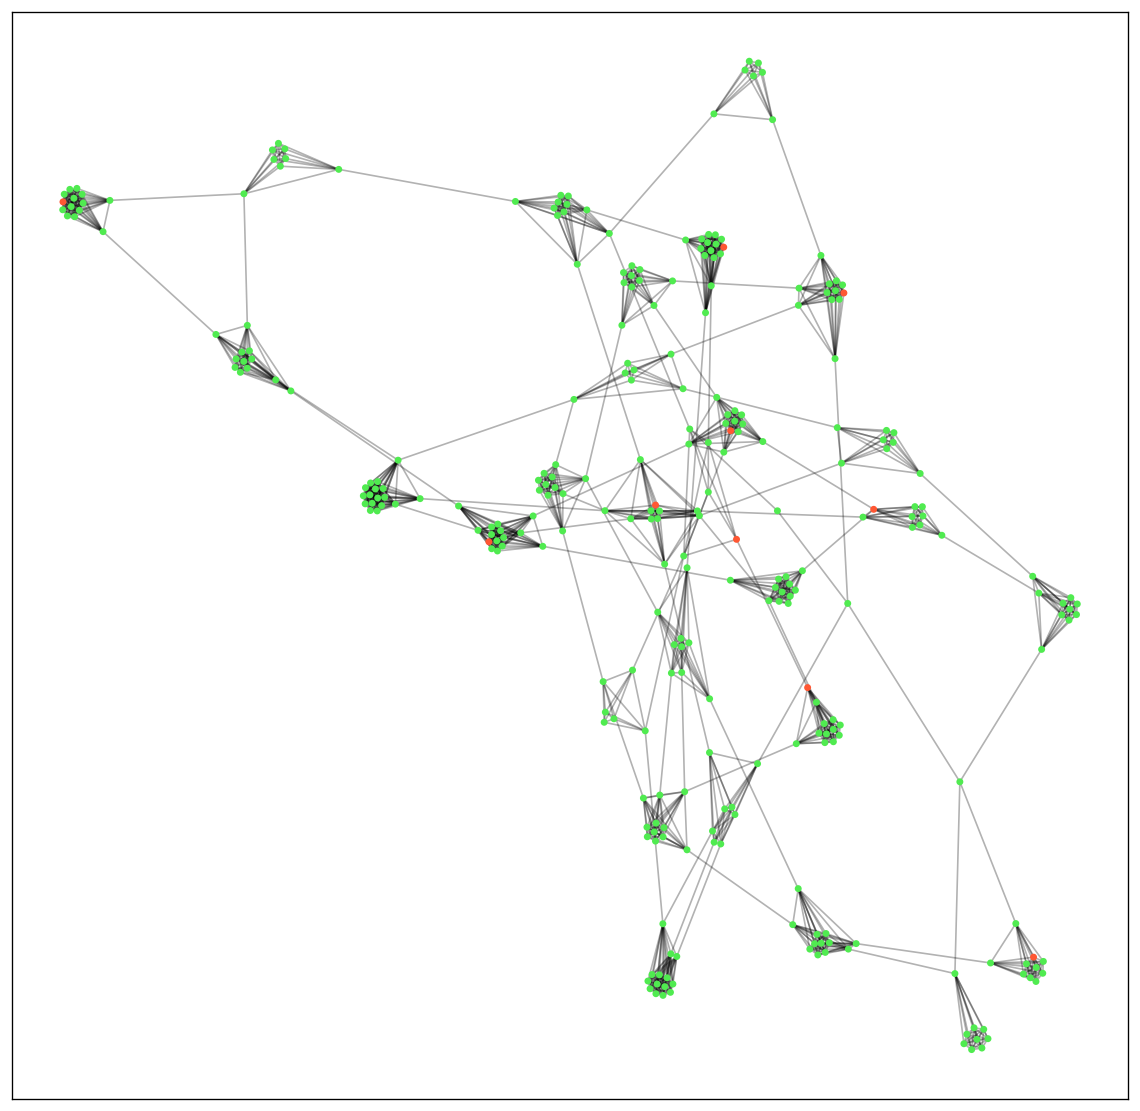

In [8]:
model._reset()
model._run_setup()
plot_model(model)

## Initial conditions are random - visualize again

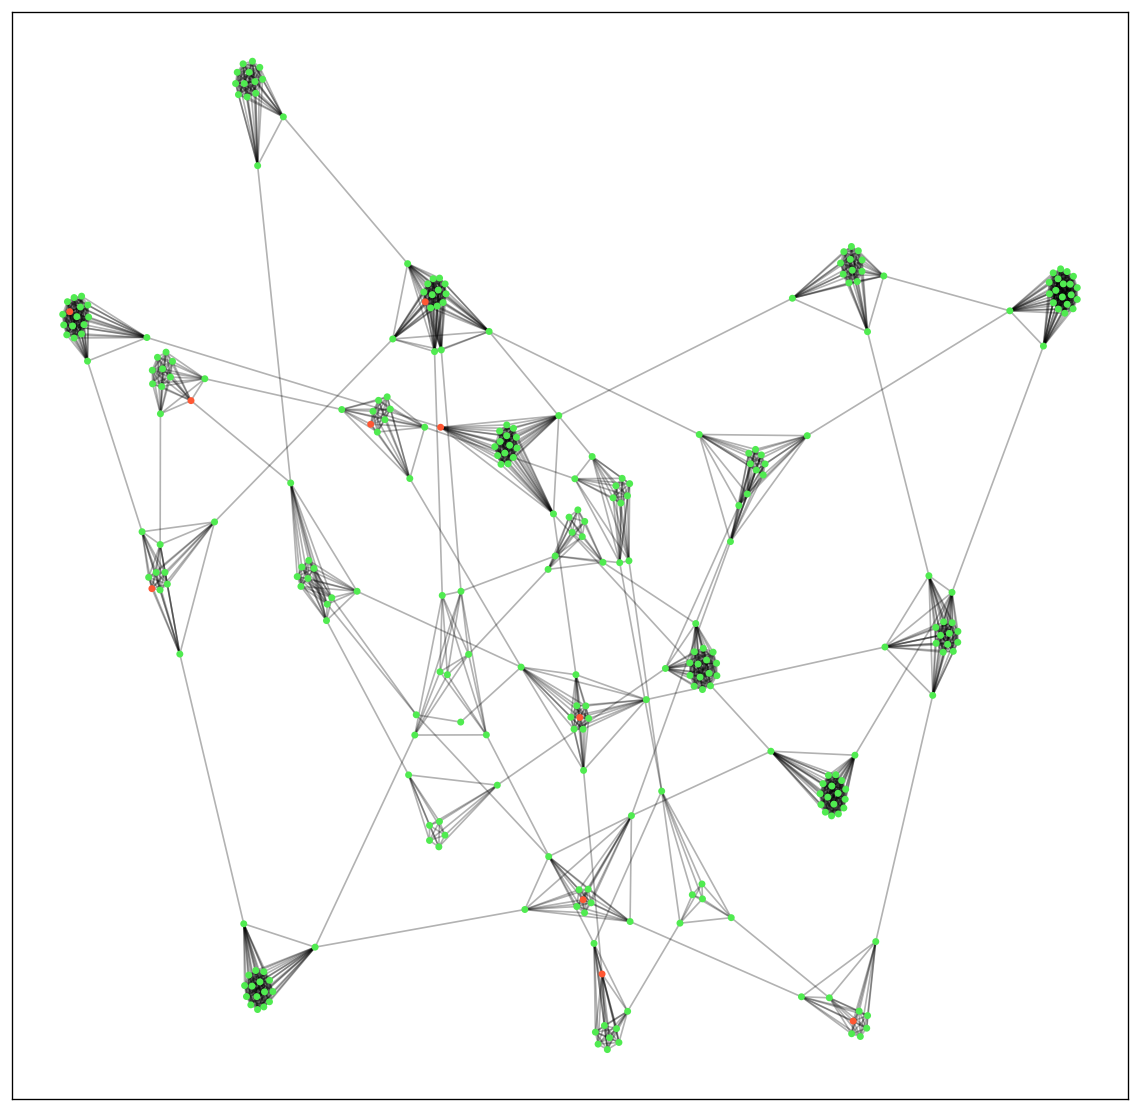

In [9]:
model._reset()
model._run_setup()
plot_model(model)

## Add model dynamics via 'systems'

In [10]:
INFECTION_PR = 0.4

def recovery_system(model: AgentModel, time: float):
    # Everyone who recovers by this date should be set to recovered
    model.agents.query.filter(
        disease=Disease.INFECTED, recovery_date__lte=time, recovery_date__gte=0
    ).update(disease=Disease.RECOVERED)


def death_system(model: AgentModel, time: float):
    # Everyone who dies by this date should be set to dead
    model.agents.query.filter(
        disease=Disease.INFECTED, death_date__lte=time, death_date__gte=0
    ).update(disease=Disease.DEAD)


def infection_system(model: AgentModel, time: float):
    for network_id in model.networks.query.ids():
        # Select infected agents in the network
        network_agent_ids = model.networks.get_nodes(network_id)
        inf_agent_ids = (
            model.agents.query.select(network_agent_ids).filter(disease=Disease.INFECTED).ids()
        )
        for agent_id in inf_agent_ids:
            # Find contacts of an agent and choose some of them to infect.
            contact_ids = model.networks.get_node_contacts(network_id, agent_id)
            inf_contacts_query = (
                model.agents.query.select(contact_ids)
                .filter(disease=Disease.SUSCEPTIBLE)
                .where(choose_infected)
            )
            apply_infection(inf_contacts_query, time)


@vectorized
@arguments("id")
def choose_infected(ids):
    """
    Returns an array of bools to select who gets infected
    """
    return np.random.random(len(ids)) <= INFECTION_PR

            
model.add_runtime_step(recovery_system)
model.add_runtime_step(death_system)
model.add_runtime_step(infection_system)

## Run the model, plotting each timestep

In [11]:
plots = []

def setup_hook(model):
    plots.append(plot_model_as_buf(model))
    

def timestep_hook(model, time):
    print("Time", time)
    plots.append(plot_model_as_buf(model))
    
model.add_setup_hook(setup_hook)
model.add_timestep_hook(timestep_hook) 

In [12]:
model.run()

Time 0.0
Time 1.0
Time 2.0
Time 3.0
Time 4.0
Time 5.0
Time 6.0
Time 7.0
Time 8.0
Time 9.0
Time 10.0
Time 11.0
Time 12.0


## Visualize model state over time


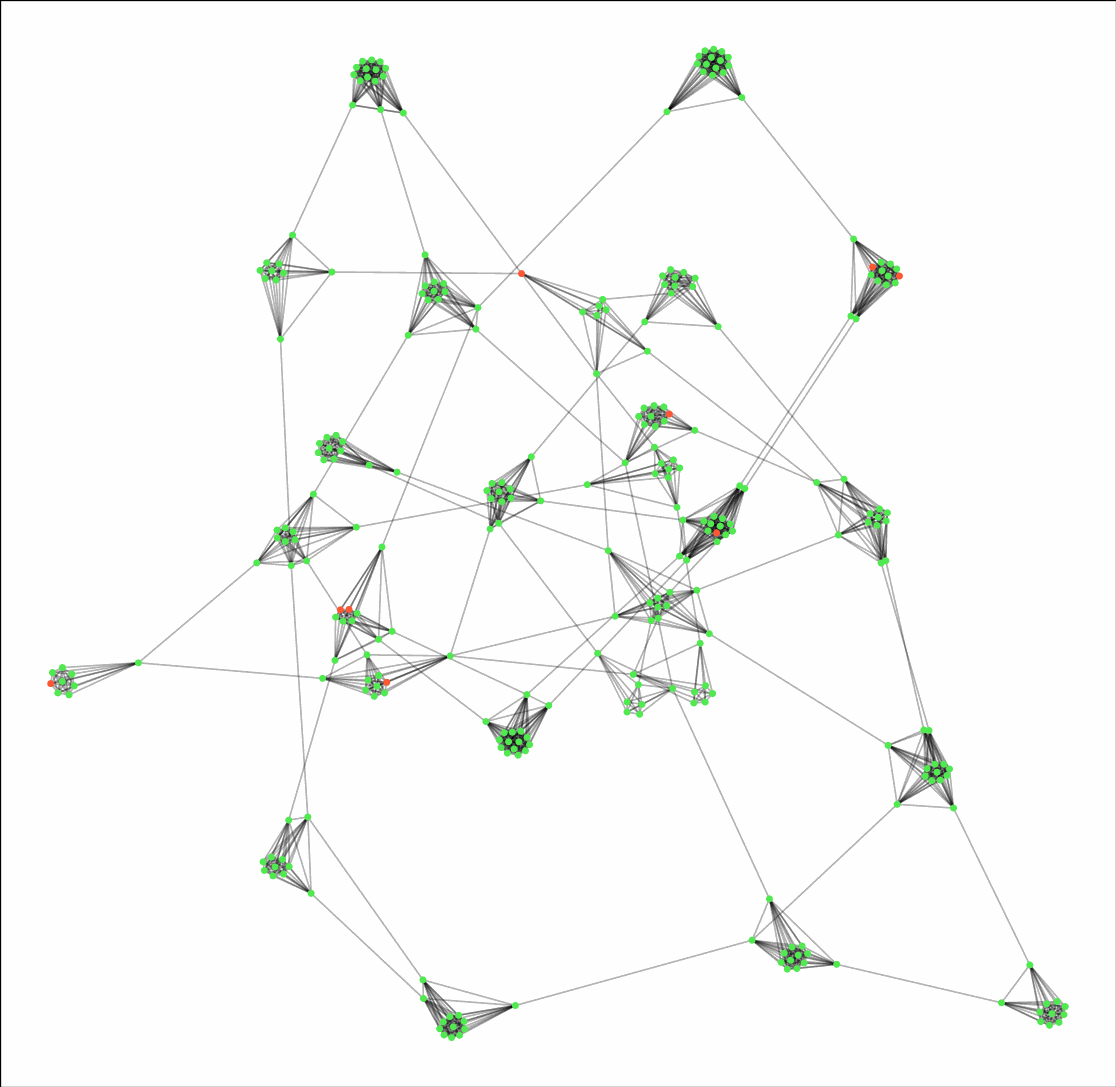

In [13]:
gif_buf = plt.plots_to_gif_buf(plots, duration=800)
plt.ipython_display_gif_buf(gif_buf)